In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='whitegrid')

import warnings
warnings.filterwarnings('ignore')

In [66]:
import os

DIRNAME = './data'
if os.path.exists(DIRNAME):
    train = pd.read_csv(DIRNAME + '/train.csv')
    print(f'Train shape: {train.shape}')
    
    test = pd.read_csv(DIRNAME + '/test.csv')
    print(f'Test shape: {test.shape}')

df_combined = pd.concat(objs=(train,test), axis=0)
print(f'Combined data sets shape: {df_combined.shape}')


Train shape: (1460, 81)
Test shape: (1459, 80)
Combined data sets shape: (2919, 81)


In [67]:
if df_combined.index.duplicated().sum() > 0:
    df_combined.reset_index(drop=True, inplace=True)

df_combined.index.duplicated().sum()

0

In [68]:
df_combined.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,...,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,...,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,...,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,...,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,...,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0


In [69]:
df_combined.drop('Id', axis=1, inplace=True)

In [70]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2919 non-null   int64  
 1   MSZoning       2915 non-null   object 
 2   LotFrontage    2433 non-null   float64
 3   LotArea        2919 non-null   int64  
 4   Street         2919 non-null   object 
 5   Alley          198 non-null    object 
 6   LotShape       2919 non-null   object 
 7   LandContour    2919 non-null   object 
 8   Utilities      2917 non-null   object 
 9   LotConfig      2919 non-null   object 
 10  LandSlope      2919 non-null   object 
 11  Neighborhood   2919 non-null   object 
 12  Condition1     2919 non-null   object 
 13  Condition2     2919 non-null   object 
 14  BldgType       2919 non-null   object 
 15  HouseStyle     2919 non-null   object 
 16  OverallQual    2919 non-null   int64  
 17  OverallCond    2919 non-null   int64  
 18  YearBuil

In [71]:
missing_values_df = df_combined.loc[:, df_combined.isnull().sum() > 0]
missing_values_series = missing_values_df.isnull().sum()

Text(0.5, 1.0, 'Missing Values per Feature')

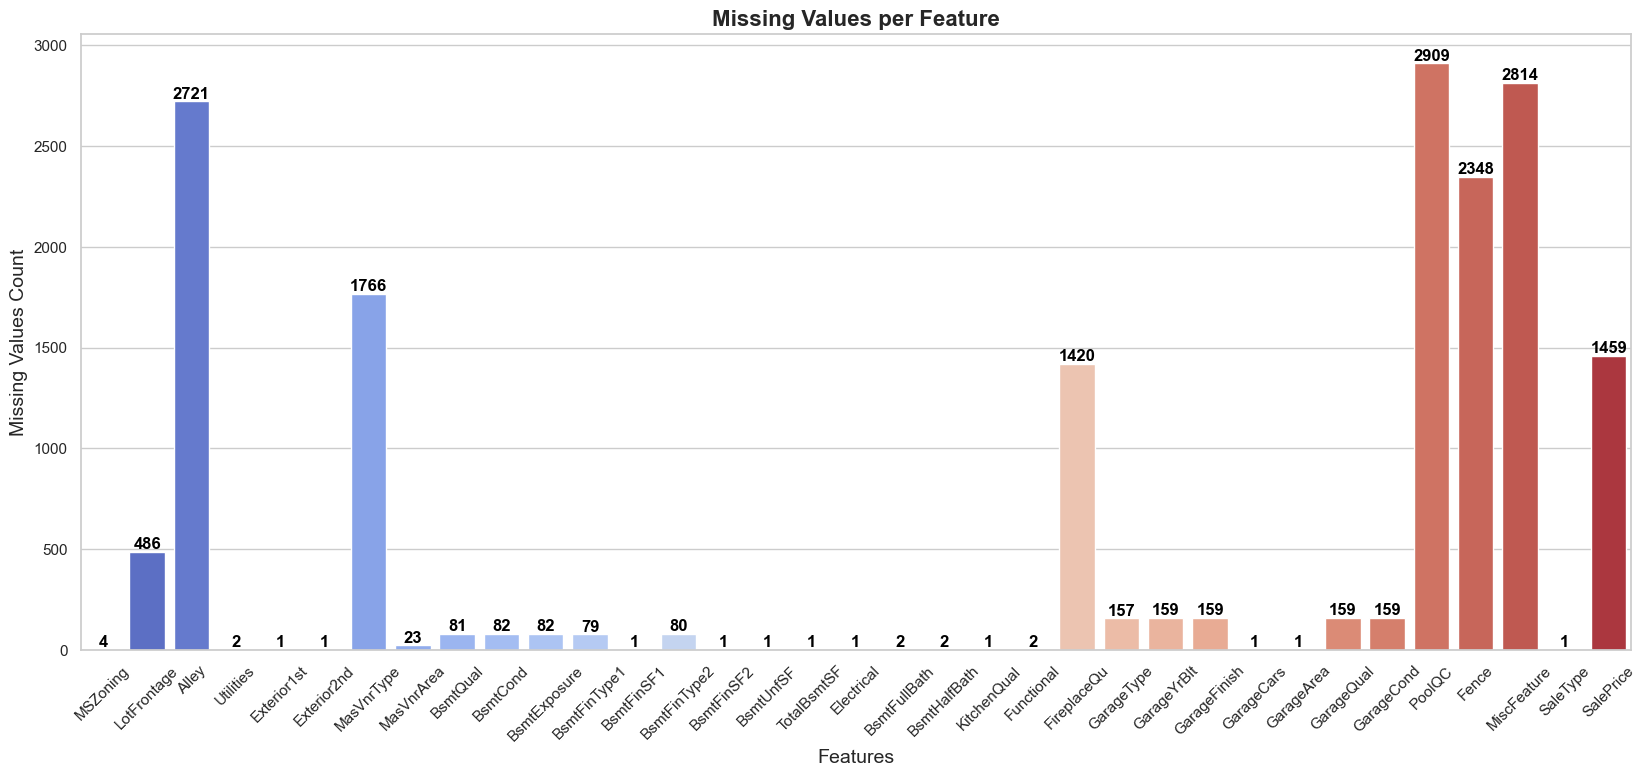

In [72]:
fig, ax = plt.subplots(figsize=(20, 8))

sns.barplot(x = missing_values_series.index,
            y = missing_values_series.values,
            palette=sns.color_palette('coolwarm', len(missing_values_series)),
            ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom', fontsize=12, color='black', fontweight='bold')
    
ax.set_ylabel("Missing Values Count", fontsize=14)
ax.set_xlabel("Features", fontsize=14)
ax.set_title("Missing Values per Feature", fontsize=16, fontweight="bold")

In [73]:
mv_df = pd.DataFrame(data = {'count_of_mv': missing_values_series.values},
                     index = missing_values_series.index)

mv_df['percent_mv'] = np.round(mv_df['count_of_mv'] / df_combined.shape[0],4)
mv_df.sort_values(by='percent_mv', ascending=False).head(10)

,count_of_mv,percent_mv
PoolQC,2909,0.9966
MiscFeature,2814,0.9640
Alley,2721,0.9322
Fence,2348,0.8044
MasVnrType,1766,0.6050
SalePrice,1459,0.4998
FireplaceQu,1420,0.4865
LotFrontage,486,0.1665
GarageCond,159,0.0545
GarageYrBlt,159,0.0545


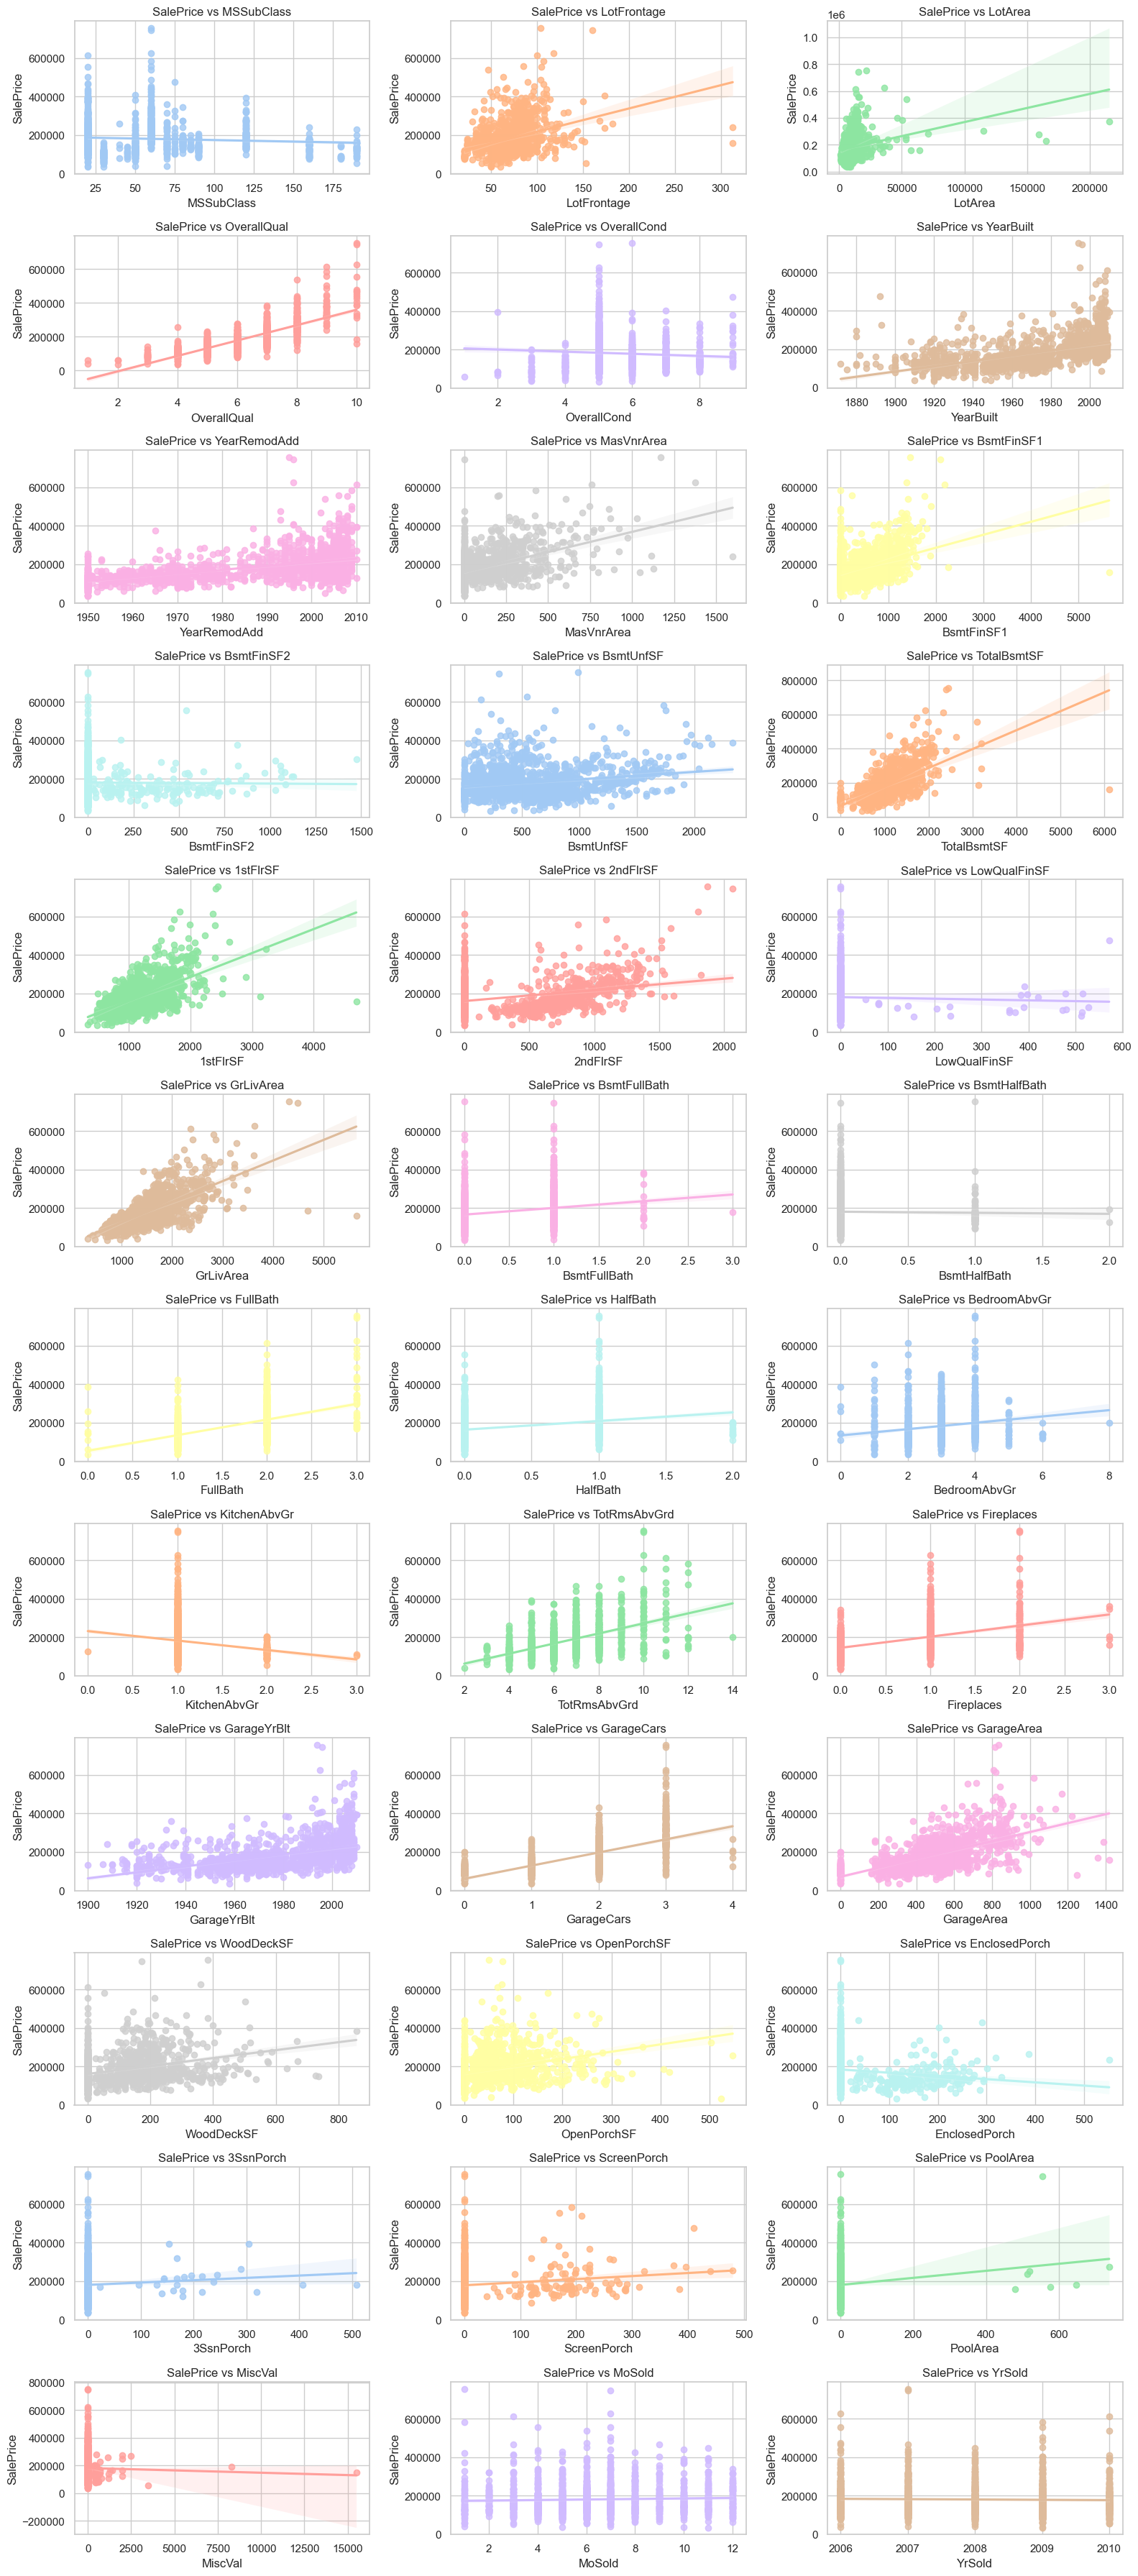

In [74]:
num_cols = [col for col in df_combined if pd.api.types.is_numeric_dtype(df_combined[col])]
cat_cols = [col for col in df_combined if pd.api.types.is_object_dtype(df_combined[col]) or pd.api.types.is_categorical_dtype(df_combined[col])]

num_cols.remove('SalePrice')

nplots = len(num_cols)
ncols = 3
nrows = int(np.ceil(nplots / ncols))

colors = sns.color_palette("pastel", n_colors=max(nplots, 1))
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16 ,3*nrows))
ax = ax.flatten()
for idx, col in enumerate(num_cols):
    sns.regplot(data=df_combined,
                x = col,
                y = 'SalePrice',
                color = colors[idx],
                ax=ax[idx])
    ax[idx].set_title(f'SalePrice vs {col}')

for i in range(idx + 1, len(ax)):  
    fig.delaxes(ax[i])
    
fig.tight_layout()

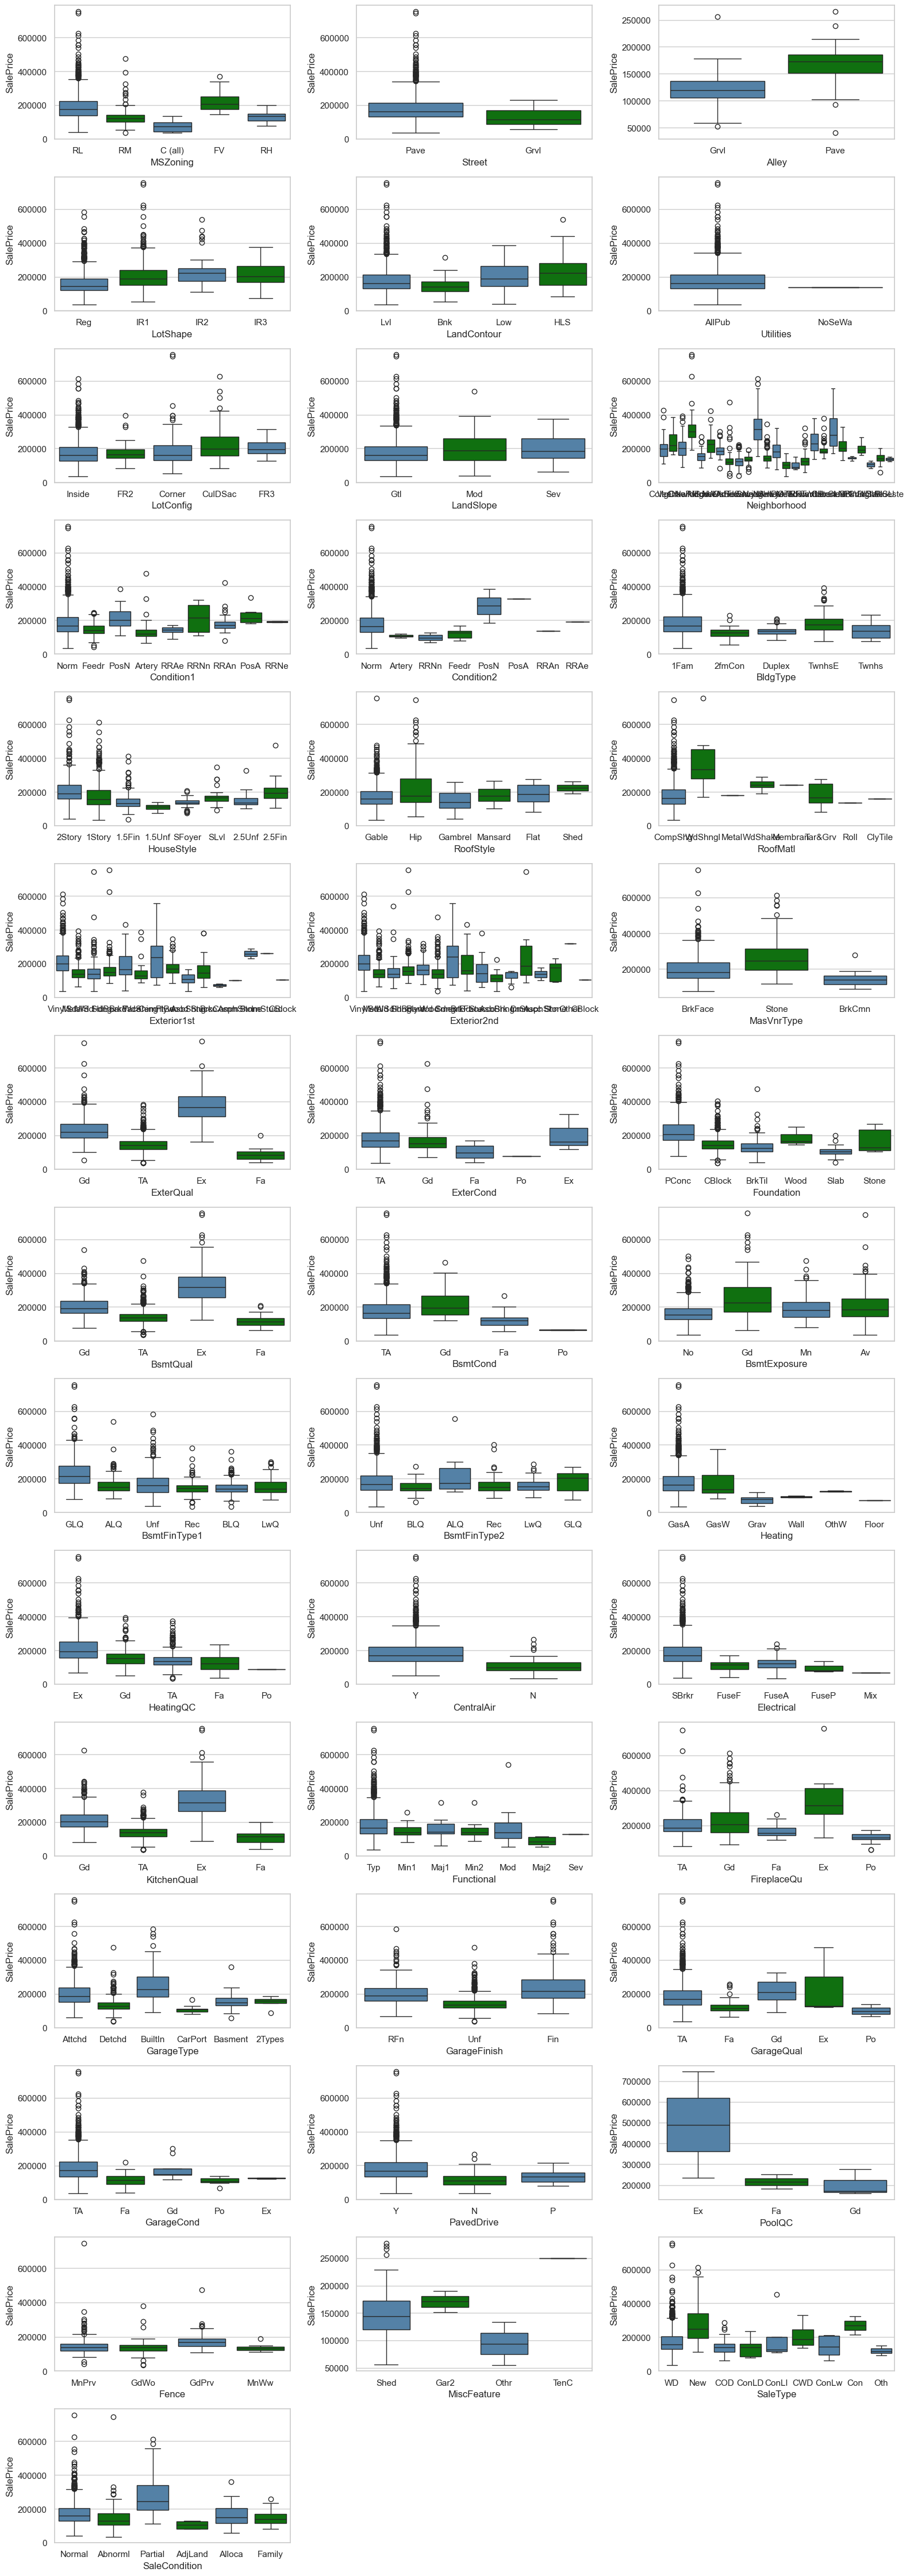

In [75]:
nplots = len(cat_cols)
ncols = 3
nrows = int(np.ceil(nplots / ncols))

fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(16, 3*nrows))
ax = ax.flatten()
for idx, col in enumerate(cat_cols):
    sns.boxplot(data=df_combined,
                x = col,
                y = 'SalePrice',
                ax=ax[idx],
                palette=['steelblue', 'green'])
    
for i in range(idx + 1, len(ax)):  
    fig.delaxes(ax[i])
    
fig.tight_layout()

In [76]:
def get_mv(data: pd.DataFrame, columns: list[str]) -> dict | str:
    coppied_data = data.copy()
    mv_cat = coppied_data[columns].loc[:, (coppied_data[columns].isnull().sum() > 0).values].columns
    if mv_cat.empty:
        return "Brak brakujących wartości w kolumnach."
    else:
        count_values_dict = {}
        for col in mv_cat:
            condition = coppied_data[col].value_counts(dropna=False).index.isna()
            count_values_dict[col] = int(coppied_data[col].value_counts(dropna=False).get(np.nan, 0))
    return count_values_dict
get_mv(df_combined, cat_cols)

{'MSZoning': 4,
 'Alley': 2721,
 'Utilities': 2,
 'Exterior1st': 1,
 'Exterior2nd': 1,
 'MasVnrType': 1766,
 'BsmtQual': 81,
 'BsmtCond': 82,
 'BsmtExposure': 82,
 'BsmtFinType1': 79,
 'BsmtFinType2': 80,
 'Electrical': 1,
 'KitchenQual': 1,
 'Functional': 2,
 'FireplaceQu': 1420,
 'GarageType': 157,
 'GarageFinish': 159,
 'GarageQual': 159,
 'GarageCond': 159,
 'PoolQC': 2909,
 'Fence': 2348,
 'MiscFeature': 2814,
 'SaleType': 1}

In [77]:
df_combined['Alley'].fillna('No Alley', inplace=True)

df_combined['BsmtQual'].fillna('No Basement', inplace=True)
df_combined['BsmtCond'].fillna('No Basement', inplace=True)
df_combined['BsmtExposure'].fillna('No Basement', inplace=True)
df_combined['BsmtFinType1'].fillna('No Basement', inplace=True)

df_combined['BsmtFinType2'].fillna('No Basement', inplace=True)

df_combined['FireplaceQu'].fillna('No Fireplace', inplace=True)

df_combined['GarageType'].fillna('No Garage', inplace=True)
df_combined['GarageFinish'].fillna('No Garage', inplace=True)
df_combined['GarageQual'].fillna('No Garage', inplace=True)
df_combined['GarageCond'].fillna('No Garage', inplace=True)

#PoolArea
df_combined['PoolQC'].fillna('No Pool', inplace=True)

df_combined['Fence'].fillna('No Fence', inplace=True)

df_combined['MiscFeature'].fillna('NA', inplace=True)
#MiscVal

df_combined['MasVnrType'].fillna('No Masonry', inplace=True)



In [78]:
get_mv(df_combined, cat_cols)

{'MSZoning': 4,
 'Utilities': 2,
 'Exterior1st': 1,
 'Exterior2nd': 1,
 'Electrical': 1,
 'KitchenQual': 1,
 'Functional': 2,
 'SaleType': 1}

In [79]:
get_mv(df_combined, num_cols)

{'LotFrontage': 486,
 'MasVnrArea': 23,
 'BsmtFinSF1': 1,
 'BsmtFinSF2': 1,
 'BsmtUnfSF': 1,
 'TotalBsmtSF': 1,
 'BsmtFullBath': 2,
 'BsmtHalfBath': 2,
 'GarageYrBlt': 159,
 'GarageCars': 1,
 'GarageArea': 1}

In [80]:
col_mv_indicator = ['LotFrontage', 'MasVnrArea','BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageYrBlt', 'GarageCars', 'GarageArea']
for col in col_mv_indicator:
    df_combined[f'missing_{col}'] = df_combined[col].isna().astype(int)


df_combined['LotFrontage'].fillna(0, inplace=True)
df_combined['MasVnrArea'].fillna(0, inplace=True)

condition = (df_combined['BsmtFinType1'] == 'No Basement') & (df_combined['BsmtFinSF1'].isna())
df_combined.loc[condition, 'BsmtFinSF1'] = 0

condition = (df_combined['BsmtFinType2'] == 'No Basement') & (df_combined['BsmtFinSF2'].isna())
df_combined.loc[condition, 'BsmtFinSF2'] = 0

condition = (df_combined['BsmtFinType1'] == 'No Basement') & (df_combined['BsmtUnfSF'].isna())
df_combined.loc[condition, 'BsmtUnfSF'] = 0

condition = (df_combined['BsmtFinType1'] == 'No Basement') & (df_combined['TotalBsmtSF'].isna())
df_combined.loc[condition, 'TotalBsmtSF'] = 0

condition = (df_combined['BsmtQual'] == 'No Basement') & (df_combined['BsmtFullBath'].isna())
df_combined.loc[condition, 'BsmtFullBath'] = 0

condition = (df_combined['BsmtQual'] == 'No Basement') & (df_combined['BsmtHalfBath'].isna())
df_combined.loc[condition, 'BsmtHalfBath'] = 0

condition = (df_combined['GarageCond'] == 'No Garage') & (df_combined['GarageYrBlt'].isna())
df_combined.loc[condition, 'GarageYrBlt'] = 0

condition = (df_combined['GarageCond'] == 'No Garage') & (df_combined['GarageCars'].isna())
df_combined.loc[condition, 'GarageCars'] = 0

condition = (df_combined['GarageCond'] == 'No Garage') & (df_combined['GarageArea'].isna())
df_combined.loc[condition, 'GarageArea'] = 0

In [81]:
get_mv(df_combined, num_cols)

'Brak brakujących wartości w kolumnach.'

In [82]:
#Label Encoding in ordincal categories

mapping_dict = {
    "LotShape": {"Reg": 3, "IR1": 2, "IR2": 1, "IR3": 0},
    "LandContour": {"Lvl": 3, "Bnk": 2, "HLS": 1, "Low": 0},
    "LandSlope": {"Gtl": 2, "Mod": 1, "Sev": 0},
    "ExterQual": {"Ex": 4, "Gd": 3, "TA": 2, "Fa": 1, "Po": 0},
    "ExterCond": {"Ex": 4, "Gd": 3, "TA": 2, "Fa": 1, "Po": 0},
    "BsmtQual": {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, "No Basement": 0},
    "BsmtCond": {"Ex": 4, "Gd": 3, "TA": 2, "Fa": 1, "Po": 0, "No Basement": 0},
    "BsmtExposure": {"Gd": 4, "Av": 3, "Mn": 2, "No": 1, "No Basement": 0},
    "BsmtFinType1": {"GLQ": 5, "ALQ": 4, "BLQ": 3, "Rec": 2, "LwQ": 1, "Unf": 0, "No Basement": 0},
    "BsmtFinType2": {"GLQ": 5, "ALQ": 4, "BLQ": 3, "Rec": 2, "LwQ": 1, "Unf": 0, "No Basement": 0},
    "HeatingQC": {"Ex": 4, "Gd": 3, "TA": 2, "Fa": 1, "Po": 0},
    "KitchenQual": {"Ex": 4, "Gd": 3, "TA": 2, "Fa": 1, "Po": 0},
    "FireplaceQu": {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, "No Fireplace": 0},
    "GarageFinish": {"Fin": 3, "RFn": 2, "Unf": 1, "No Garage": 0},
    "GarageQual": {"Ex": 4, "Gd": 3, "TA": 2, "Fa": 1, "Po": 0, "No Garage": 0},
    "GarageCond": {"Ex": 4, "Gd": 3, "TA": 2, "Fa": 1, "Po": 0, "No Garage": 0},
    "PoolQC": {"Ex": 4, "Gd": 3, "TA": 2, "Fa": 1, "No Pool": 0},
    "Fence": {"GdPrv": 4, "MnPrv": 3, "GdWo": 2, "MnWw": 1, "No Fence": 0},
    'Functional': {'Typ': 7, 'Min1': 6, 'Min2': 5, 'Mod': 4, 'Maj1': 3, 'Maj2': 2, 'Sev': 1, 'Sal': 0
}
}


def encode_features(df, mapping_dict):
    for feature, mapping in mapping_dict.items():
        if feature in df.columns:
            df[feature] = df[feature].map(mapping)
    return df

df_labeled = encode_features(df_combined, mapping_dict)


In [83]:
object_cols = df_labeled.select_dtypes(include = object).columns
object_cols

Index(['MSZoning', 'Street', 'Alley', 'Utilities', 'LotConfig', 'Neighborhood',
       'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation',
       'Heating', 'CentralAir', 'Electrical', 'GarageType', 'PavedDrive',
       'MiscFeature', 'SaleType', 'SaleCondition'],
      dtype='object')

In [84]:
df_labeled["BuiltAge"]  = df_labeled["YearBuilt"].max() - df_labeled["YearBuilt"]
df_labeled["RemodAddAge"] = df_labeled["YearRemodAdd"].max() - df_labeled["YearRemodAdd"]
df_labeled["GarageBuiltAge"] = df_labeled["GarageYrBlt"].max() - df_labeled["GarageYrBlt"]

df_labeled.drop(columns=["YearBuilt", "YearRemodAdd", "GarageYrBlt"], axis=1, inplace=True)

In [85]:
from sklearn.preprocessing import OrdinalEncoder
from catboost import CatBoostRegressor

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

ordinal_encoder = OrdinalEncoder()

df_X = df_labeled.drop('SalePrice', axis=1)
df_Y = df_labeled['SalePrice']

df_X[object_cols] = ordinal_encoder.fit_transform(df_X[object_cols])
catboost_regressor = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    verbose=0,
    random_state=0
)

imputer = IterativeImputer(estimator=catboost_regressor, random_state=0)
df_imputed = pd.DataFrame(imputer.fit_transform(df_X), columns=df_X.columns)

df_imputed[object_cols] = df_imputed[object_cols].round().astype(int)
df_imputed[object_cols] = ordinal_encoder.inverse_transform(df_imputed[object_cols])
df_imputed.head()


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,...,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,missing_LotFrontage,missing_MasVnrArea,missing_BsmtFinSF1,missing_BsmtFinSF2,missing_BsmtUnfSF,missing_TotalBsmtSF,missing_BsmtFullBath,missing_BsmtHalfBath,missing_GarageYrBlt,missing_GarageCars,missing_GarageArea,BuiltAge,RemodAddAge,GarageBuiltAge
0,60.0,RL,65.0,8450.0,Pave,No Alley,3.0,3.0,AllPub,Inside,2.0,CollgCr,Norm,Norm,1Fam,2Story,7.0,5.0,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,3.0,2.0,PConc,4.0,2.0,1.0,5.0,706.0,0.0,0.0,150.0,856.0,GasA,4.0,Y,SBrkr,...,3.0,8.0,7.0,0.0,0.0,Attchd,2.0,2.0,548.0,2.0,2.0,Y,0.0,61.0,0.0,0.0,0.0,0.0,0.0,0.0,NA,0.0,2.0,2008.0,WD,Normal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,7.0,204.0
1,20.0,RL,80.0,9600.0,Pave,No Alley,3.0,3.0,AllPub,FR2,2.0,Veenker,Feedr,Norm,1Fam,1Story,6.0,8.0,Gable,CompShg,MetalSd,MetalSd,No Masonry,0.0,2.0,2.0,CBlock,4.0,2.0,4.0,4.0,978.0,0.0,0.0,284.0,1262.0,GasA,4.0,Y,SBrkr,...,2.0,6.0,7.0,1.0,3.0,Attchd,2.0,2.0,460.0,2.0,2.0,Y,298.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NA,0.0,5.0,2007.0,WD,Normal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.0,34.0,231.0
2,60.0,RL,68.0,11250.0,Pave,No Alley,2.0,3.0,AllPub,Inside,2.0,CollgCr,Norm,Norm,1Fam,2Story,7.0,5.0,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,3.0,2.0,PConc,4.0,2.0,2.0,5.0,486.0,0.0,0.0,434.0,920.0,GasA,4.0,Y,SBrkr,...,3.0,6.0,7.0,1.0,3.0,Attchd,2.0,2.0,608.0,2.0,2.0,Y,0.0,42.0,0.0,0.0,0.0,0.0,0.0,0.0,NA,0.0,9.0,2008.0,WD,Normal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,8.0,206.0
3,70.0,RL,60.0,9550.0,Pave,No Alley,2.0,3.0,AllPub,Corner,2.0,Crawfor,Norm,Norm,1Fam,2Story,7.0,5.0,Gable,CompShg,Wd Sdng,Wd Shng,No Masonry,0.0,2.0,2.0,BrkTil,3.0,3.0,1.0,4.0,216.0,0.0,0.0,540.0,756.0,GasA,3.0,Y,SBrkr,...,3.0,7.0,7.0,1.0,4.0,Detchd,1.0,3.0,642.0,2.0,2.0,Y,0.0,35.0,272.0,0.0,0.0,0.0,0.0,0.0,NA,0.0,2.0,2006.0,WD,Abnorml,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,95.0,40.0,209.0
4,60.0,RL,84.0,14260.0,Pave,No Alley,2.0,3.0,AllPub,FR2,2.0,NoRidge,Norm,Norm,1Fam,2Story,8.0,5.0,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,3.0,2.0,PConc,4.0,2.0,3.0,5.0,655.0,0.0,0.0,490.0,1145.0,GasA,4.0,Y,SBrkr,...,3.0,9.0,7.0,1.0,3.0,Attchd,2.0,3.0,836.0,2.0,2.0,Y,192.0,84.0,0.0,0.0,0.0,0.0,0.0,0.0,NA,0.0,12.0,2008.0,WD,Normal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,10.0,207.0


In [86]:
df_imputed.isnull().sum().sort_values()

MSSubClass        0
EnclosedPorch     0
OpenPorchSF       0
WoodDeckSF        0
PavedDrive        0
                 ..
Foundation        0
ExterCond         0
ExterQual         0
MasVnrType        0
GarageBuiltAge    0
Length: 90, dtype: int64

In [87]:
df_imputed.shape

(2919, 90)

In [88]:
df_all = pd.concat(objs=[df_imputed, df_Y], axis=1)
df_all.reset_index(drop=True, inplace=True)

In [89]:
numeric_features = df_all.select_dtypes(include = [np.number])
numeric_features = numeric_features.columns.difference(['SalePrice'])

In [90]:
skewed = df_all[numeric_features].apply(lambda col: col.skew())
skewed = skewed[skewed.abs() > 0].index
skewed

Index(['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'BedroomAbvGr', 'BsmtCond',
       'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFinType1',
       'BsmtFinType2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtQual', 'BsmtUnfSF',
       'BuiltAge', 'EnclosedPorch', 'ExterCond', 'ExterQual', 'Fence',
       'FireplaceQu', 'Fireplaces', 'FullBath', 'Functional', 'GarageArea',
       'GarageBuiltAge', 'GarageCars', 'GarageCond', 'GarageFinish',
       'GarageQual', 'GrLivArea', 'HalfBath', 'HeatingQC', 'KitchenAbvGr',
       'KitchenQual', 'LandContour', 'LandSlope', 'LotArea', 'LotFrontage',
       'LotShape', 'LowQualFinSF', 'MSSubClass', 'MasVnrArea', 'MiscVal',
       'MoSold', 'OpenPorchSF', 'OverallCond', 'OverallQual', 'PoolArea',
       'PoolQC', 'RemodAddAge', 'ScreenPorch', 'TotRmsAbvGrd', 'TotalBsmtSF',
       'WoodDeckSF', 'YrSold', 'missing_BsmtFinSF1', 'missing_BsmtFinSF2',
       'missing_BsmtFullBath', 'missing_BsmtHalfBath', 'missing_BsmtUnfSF',
       'missing_GarageArea', 'missing

In [91]:
from scipy.stats import boxcox, probplot

df_processed = df_all.copy()
df_processed[skewed] = df_processed[skewed].apply(lambda col: boxcox(col)[0] if col.min() > 0 else boxcox(col - col.min() + 1)[0])

((array([-3.30513952, -3.04793228, -2.90489705, ...,  2.90489705,
          3.04793228,  3.30513952]),
  array([ 34900.,  35311.,  37900., ..., 625000., 745000., 755000.])),
 (74160.16474519415, 180921.19589041095, 0.9319665641512986))

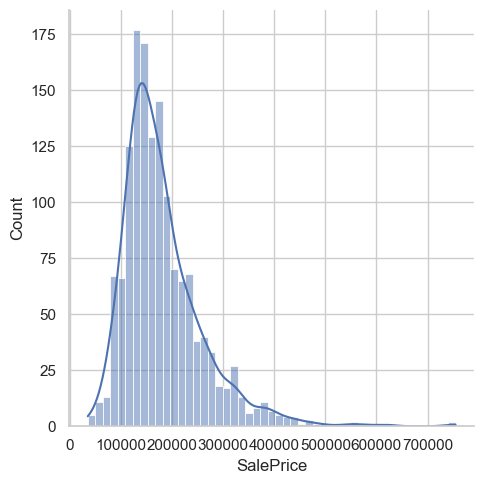

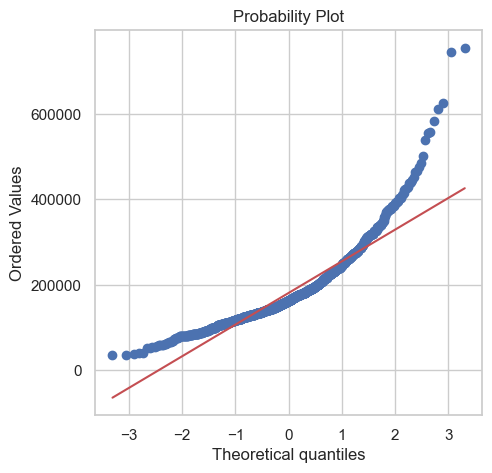

In [92]:
df_notna_saleprice = df_processed[df_processed['SalePrice'].notna()]

sns.displot(data=df_notna_saleprice,
            x = 'SalePrice',
            kde = True)

fig, ax = plt.subplots(figsize=(5,5))
probplot(x = df_notna_saleprice['SalePrice'], dist='norm', plot=ax)


((array([-3.30513952, -3.04793228, -2.90489705, ...,  2.90489705,
          3.04793228,  3.30513952]),
  array([10.46027076, 10.47197813, 10.54273278, ..., 13.34550853,
         13.52114084, 13.53447435])),
 (0.398259646654151, 12.024057394918403, 0.9953761551826701))

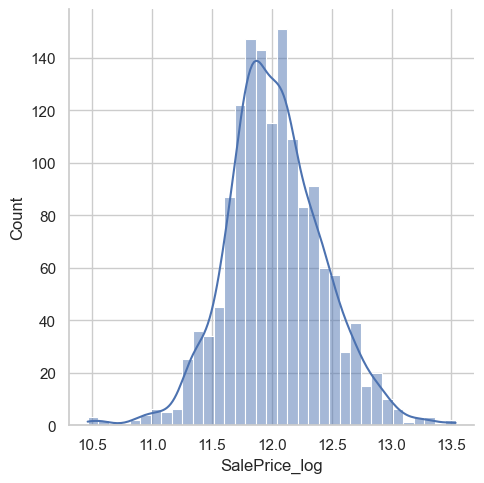

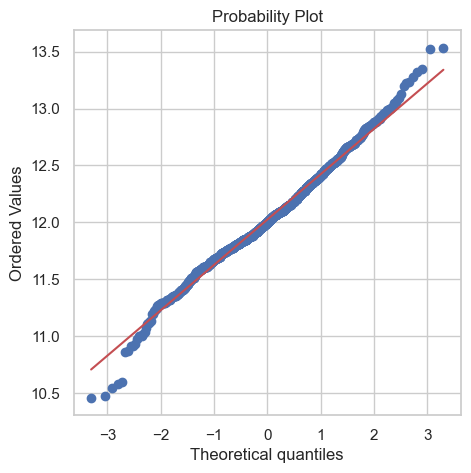

In [93]:
df_notna_saleprice['SalePrice_log'] = np.log1p(df_notna_saleprice['SalePrice'])

sns.displot(data=df_notna_saleprice, x='SalePrice_log', kde=True)

fig, ax = plt.subplots(figsize=(5,5))
probplot(df_notna_saleprice['SalePrice_log'], dist='norm', plot=ax)

In [94]:
df_processed['SalePrice_log'] = np.log1p(df_processed['SalePrice'])

In [95]:
df_processed.drop('SalePrice', axis=1, inplace=True)

In [96]:
object_cols = df_processed.select_dtypes(include = [object]).columns
df_onehot = pd.get_dummies(df_processed, columns=object_cols, drop_first=True)
df_onehot.shape

(2919, 213)

In [97]:
train = df_onehot[df_onehot['SalePrice_log'].notna()]
test = df_onehot[~df_onehot['SalePrice_log'].notna()]

print(train.shape)
print(test.shape)

(1460, 213)
(1459, 213)


In [98]:
X = train.drop('SalePrice_log', axis=1)
y = train['SalePrice_log']

In [99]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X))

In [100]:
from sklearn.linear_model import LassoCV
lasso_cv = LassoCV(max_iter=1000, cv=5, random_state=42)
lasso_cv.fit(X_scaled, y)

LassoCV(cv=5, random_state=42)

In [101]:
selected_features = list(X.columns[(lasso_cv.coef_ != 0)])
selected_features.append('SalePrice_log')

In [102]:
df_selected_features = df_onehot[selected_features]

In [103]:
df_selected_features.shape

(2919, 73)

In [104]:
df_train = df_selected_features[df_selected_features['SalePrice_log'].notna()]
df_prediction = df_selected_features[~df_selected_features['SalePrice_log'].notna()]

In [105]:
X = df_train.drop('SalePrice_log', axis=1)
y = df_train['SalePrice_log']

In [106]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV, RepeatedKFold
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

import xgboost as xgb
from sklearn.metrics import r2_score, root_mean_squared_error

RANDOM_STATE = 42
models = {
    'lasso_cv': LassoCV(),
    'tree': DecisionTreeRegressor(),
    'random_forest': RandomForestRegressor(),
    'catboost': CatBoostRegressor(verbose=0, random_state=RANDOM_STATE),
    'xgboost': xgb.XGBRegressor(objective='reg:squarederror', random_state=RANDOM_STATE)
}

param_grid = {
    'lasso_cv': {
        'alphas': [np.linspace(0.01, 0.2, 10)],
        'max_iter': [1000],
        'cv': [10],
        'n_jobs': [-1],
        'random_state': [RANDOM_STATE]
    },
    
    'tree': {
        'max_depth': [3, 5, 7, None],
        'min_samples_split': [2, 3, 4, 5],
        'min_samples_leaf': [1, 2, 10, 20, 30],
        'random_state': [RANDOM_STATE],
    },
    
    'random_forest': {
        'n_estimators': [100, 200, 500, 1000],
        'max_depth': [3, 5, 7, None],
        'min_samples_split': [2, 3, 4, 5],
        'min_samples_leaf': [1, 2, 10, 20, 30],
        'random_state': [RANDOM_STATE],
        'min_impurity_decrease': [0.0, 0.05, 0.1],
        'n_jobs': [-1],
    },
    
    'catboost': {
        'iterations': [1000],
        'learning_rate': [0.1],
        'depth': [3, 5, 7],
        'random_state': [RANDOM_STATE]
    },
    
    'xgboost': {
        'n_estimators': [100, 200, 500, 1000],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.1],
        'random_state': [RANDOM_STATE]
    }
}


results = {}

rkf = RepeatedKFold(n_splits=5, n_repeats=2, random_state=RANDOM_STATE)
for model_name, model in models.items():
    print(f'Tuning model... {model_name}')
    
    rg_search = RandomizedSearchCV(model,
                                   param_distributions=param_grid[model_name],
                                   cv=rkf,
                                   scoring='r2',
                                   n_iter=20,
                                   n_jobs=-1,
                                   random_state=RANDOM_STATE)
    
    rg_search.fit(X_train, y_train)
    best_params = rg_search.best_params_
    best_score = rg_search.best_score_

    print(f'Best params: {best_params}')
    print(f'Best cross-validation R²: {best_score:.4f}')
    
    model.set_params(**best_params)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    test_score = r2_score(y_test, y_pred)
    test_rmse = root_mean_squared_error(y_test, y_pred)
    
    print(f'Test R²: {test_score:.4f}')
    print(f'Test RMSE: {test_rmse:.4f}')
    

    results[model_name] = {
        'best_params': best_params,
        'cv_score': best_score,
        'test_score': test_score
    }


Tuning model... lasso_cv
Best params: {'random_state': 42, 'n_jobs': -1, 'max_iter': 1000, 'cv': 10, 'alphas': array([0.01      , 0.03111111, 0.05222222, 0.07333333, 0.09444444,
       0.11555556, 0.13666667, 0.15777778, 0.17888889, 0.2       ])}
Best cross-validation R²: 0.8601
Test R²: 0.8659
Tuning model... tree
Best params: {'random_state': 42, 'min_samples_split': 4, 'min_samples_leaf': 10, 'max_depth': None}
Best cross-validation R²: 0.7577
Test R²: 0.8138
Tuning model... random_forest
Best params: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 200, 'min_samples_split': 3, 'min_samples_leaf': 2, 'min_impurity_decrease': 0.0, 'max_depth': 5}
Best cross-validation R²: 0.8218
Test R²: 0.8527
Tuning model... catboost
Best params: {'random_state': 42, 'learning_rate': 0.1, 'iterations': 1000, 'depth': 5}
Best cross-validation R²: 0.9070
Test R²: 0.9010
Tuning model... xgboost
Best params: {'random_state': 42, 'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.1}
Best cross-va